In [1]:
%load_ext autoreload
%autoreload 2

import csv
from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
import re
style.use('seaborn-white')


/var/folders/dr/569_jbr5735_fltd4plxy3j00000gn/T/ipykernel_2013/1135204672.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


## generating vectors and defining useful variables

In [1]:
z = [
    2.99825,
    3.0055,
    3.02075,
    3.0285,
]

z_ref = z[0]


import random

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min

nEvents = int(1e5)

eta = np.random.rand(nEvents)*eta_range + eta_min
phi = np.random.rand(nEvents)*2*np.pi - np.pi

vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*3000)

vec_list = []
for x,y in zip(vec.x, vec.y):
    vec_list.append(three_vector(x,y,3000))

delta_z = 20.5 # approximated distance between similar layers (e.g. front disk1 - front disk 2)
colors = ['red','blue','green','yellow','black','maroon','wheat']
plt.style.use(hep.style.CMS)  # or ATLAS/LHCb
bins_1 = "50,300,1200"
bins_2 ="40,-%s,%s"%(np.pi,np.pi)
bins_3 = "40,1.659,2.950"
bins_4 = "5,-0.5,4.5"

den1 = Hist1D([v.r for v in vec_list], bins=bins_1)
den2 = Hist1D([v.phi for v in vec_list], bins=bins_2)
den3 = Hist1D([v.eta for v in vec_list], bins=bins_3)

NameError: name 'np' is not defined

## code that runs the simulation, making plots, and also finding other useful quantities

In [5]:
hists_1 = []
hists_2 = []
hists_3 = []
hists_4 = []
mean_nhits = []

# m_pix = 16
# n_pix = 16
# gap = 0.05

traject_dict = {v:[] for v in vec_list}
face_dict = {v:[] for v in vec_list}
angles_dict = {v:[] for v in vec_list}

with open('new_yamls_configs/database_new_config_2') as f:
    database_new = load(f, Loader=Loader)

disk_new = database_new['new'] 

layers = [['disk1','front'],['disk1','back'],['disk2','front'],['disk2','back']]

for i in range(2):

    if i == 1:
        break
        with open('new_yamls_configs/database_new_original filtered 800') as f:
            database_new = load(f, Loader=Loader)

        disk_new = database_new['new']

    new_layout = {}

    s = Sensor2(21.4, 21.6)
    
    new_layout['D1'] = Dee(315, 1185)
    new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

    new_layout['D2'] = Dee(315, 1185)
    new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

    new_layout['D3'] = Dee(315, 1185)
    new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

    new_layout['D4'] = Dee(315, 1185)
    new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

    # new_layout['D1'] = Dee(315, 1185)
    # new_layout['D1'].fromCenters2(disk_new['disk1']['front'], s, m_pix, n_pix, gap)

    # new_layout['D2'] = Dee(315, 1185)
    # new_layout['D2'].fromCenters2(disk_new['disk1']['back'], s, m_pix, n_pix, gap)

    # new_layout['D3'] = Dee(315, 1185)
    # new_layout['D3'].fromCenters2(disk_new['disk2']['front'], s, m_pix, n_pix, gap)

    # new_layout['D4'] = Dee(315, 1185)
    # new_layout['D4'].fromCenters2(disk_new['disk2']['back'], s, m_pix, n_pix, gap)

    hits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
        }
    
    nHits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
    }

    detector_variants = {
        
        # 'large_sensor': large_sensor,
        # #'large_sensor_v1': large_sensor_v1,
        # 'small_sensor': small_sensor,
        # #'small_sensor_v1': small_sensor_v1,
        # #'small_sensor_v2': small_sensor_v2,
        # #'small_sensor_v3': small_sensor_v3,
        # 'TDR': TDR,
        'new_layout': new_layout,
            }



    # We also want to get the number of hits.
    for v in vec_list:                                                                     
        
        for det in detector_variants:
            n = 0
            iLayer = 0

            for layer in ['D1','D2','D3','D4']:
                x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
                y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
                x,y = ((v.x + x_shift), (v.y + y_shift))
                if detector_variants[det][layer].intersect(x, y):
                    new_vector = three_vector(x,y,z[iLayer]*1000)
                    eta, phi = new_vector.eta, new_vector.phi
                    traject_dict[v].append((x,y,z[iLayer]*1000))
                    angles_dict[v].append((eta,phi))
                    face_dict[v].append(layer)
                    n += 1
                iLayer += 1
                
            if n>0: hits[det].append(v)
            
            # else:
                
            #     if i == 0:
            #         zero_hit_original.append((v.x,v.y))
            #     else:
            #         zero_hit_modified.append((v.x,v.y))
    
            # nHits[det].append(n)
            
            # if n == 3: 
            #     if i == 0:
            #         three_hit_original.append((v.x,v.y))
            #     else:
            #         three_hit_modified.append((v.x,v.y))


    
    # print(nHits['new_layout'])
    if i == 0:
        unfilled_eff = len(hits['new_layout'])/len(vec_list)
    else:
        filled_eff = len(hits['new_layout'])/len(vec_list)
    

    # num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
    # num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
    # num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
    # #num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)


    num1 = Hist1D([v.r for v in hits['new_layout']], bins=bins_1)
    num2 = Hist1D([v.phi for v in hits['new_layout']], bins=bins_2)
    num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins_3)
    
    #num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
    #num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
    #num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)



    # h0 = num0.divide(den, binomial=True)
    h1 = num1.divide(den1, binomial=True)
    h2 = num2.divide(den2, binomial=True)
    h3 = num3.divide(den3, binomial=True)
    h4 = Hist1D(nHits['new_layout'], bins=bins_4).normalize()
    #h4 = num4.divide(den, binomial=True)
    #h5 = num5.divide(den, binomial=True)
    #h6 = num6.divide(den, binomial=True)
    hists_1.append(h1)
    hists_2.append(h2)
    hists_3.append(h3)
    hists_4.append(h4)

    # fig.savefig(os.path.join("{}.pdf".format(name)))
    # fig.savefig(os.path.join("{}.png".format(name)))

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# for i in range(len(hists_1)):
#     if i == 1:
#         hists_1[i].plot(show_errors=True,color=colors[i],alpha=0.7,label='original: %.2f'%(filled_eff))

#     else:
#         hists_1[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)

# ax.set_ylabel('Efficiency')
# ax.set_xlabel('r (mm)')

# ax.set_ylim(0.05,1.05)

# fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

# name = 'efficiency_vs_r_pixeled_6_filtered'
# fig.savefig(os.path.join("{}.png".format(name)))

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# for i in range(len(hists_2)):
#     if i == 1:
#         hists_2[i].plot(show_errors=True,color=colors[i],label='original: %.2f'%(filled_eff),alpha=0.7)

#     else:
#         hists_2[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)


# ax.set_ylim(0.45,1.05)

# ax.set_ylabel('Efficiency')
# ax.set_xlabel(r'$\phi$')

# fig.text(0.0, 0.995, r'$\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

# name = 'efficiency_vs_phi_pixeled_6_filtered'
# fig.savefig(os.path.join("{}.png".format(name)))

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# for i in range(len(hists_3)):
#     if i == 1:
#         hists_3[i].plot(show_errors=True,color=colors[i],label='original: %.2f'%(filled_eff),alpha=0.7)

#     else:
#         hists_3[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)

# ax.set_ylabel('Efficiency')
# ax.set_xlabel(r'$\eta$')
# ax.set_ylim(0.05,1.05)

# name = 'efficiency_vs_eta_pixeled_6_filtered'

# fig.savefig(os.path.join("{}.png".format(name)))

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# for i in range(len(hists_4)):
#     if i == 1:
#         hists_4[i].plot(show_errors=True,histtype="step",color=colors[i],label='original layout: %.2f'%(hists_4[i].mean()),alpha=0.7)

#     else:
#         hists_4[i].plot(show_errors=True,histtype="step",color=colors[i],label='modified layout: %.2f'%(hists_4[i].mean()),alpha=0.7)

# ax.set_ylabel('Tracks')
# ax.set_xlabel('Hits')
# ax.set_ylim(0,1)
# name = 'nHits_6_filtered'

# fig.savefig(os.path.join("{}.png".format(name)))

/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.10/site-packages/yahist/hist1d.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  return self.__mul__(1.0 / other)
/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.10/site-packages/yahist/hist1d.py:481: RuntimeWarning: invalid value encountered in multiply
  hnew._counts *= fact
/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.10/site-packages/yahist/hist1d.py:482: RuntimeWarning: invalid value encountered in multiply
  hnew._errors *= fact


## code to get the particles with a specific number of hits from the dictionary defined in the cell above

In [18]:
filtered_dict_face = dict(filter(lambda x: len(x[1]) == 4, face_dict.items()))
filtered_dict_traject = dict(filter(lambda x: len(x[1]) == 4, traject_dict.items()))
filtered_dict_angles = dict(filter(lambda x: len(x[1]) == 4, angles_dict.items()))

# f = open('face_three_hits.txt', 'w')
# for i in filtered_dict_face.keys():
#     value = ''
#     for j in range(len(filtered_dict_face[i])):
#         value += filtered_dict_face[i][j] + "  " + str(filtered_dict_traject[i][j]) + "  "
#     f.write(value + '\n')

# f.close()

## histograms

Text(1, 0, 'z')

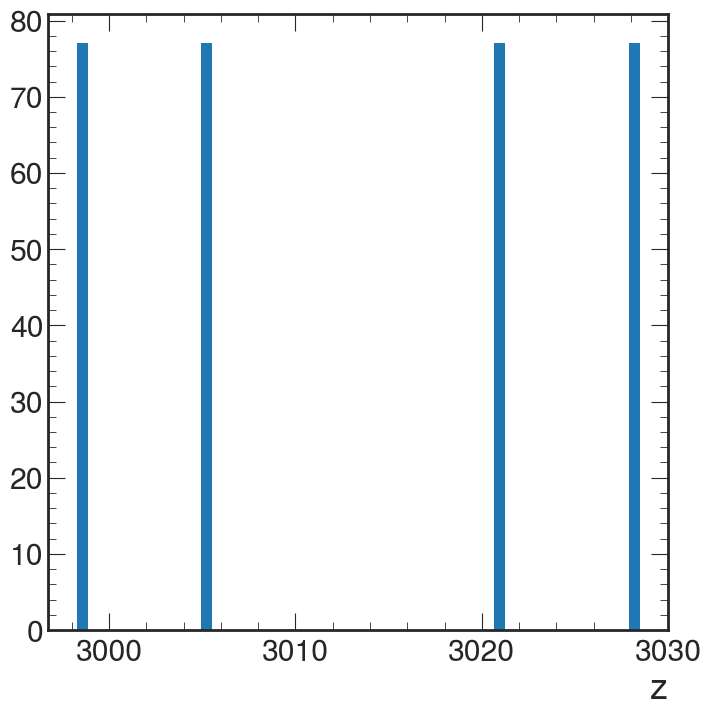

In [22]:
etas = [filtered_dict_angles[key][0][0] for key in filtered_dict_angles]
phis = [filtered_dict_angles[key][0][1] for key in filtered_dict_angles]
x,y,z = [tup[0] for key in filtered_dict_traject for tup in filtered_dict_traject[key]], [tup[1] for key in filtered_dict_traject for tup in filtered_dict_traject[key]], [tup[2] for key in filtered_dict_traject for tup in filtered_dict_traject[key]]

plt.figure(figsize=(8,8))
plt.hist(z,bins=50)
plt.xlabel('z')
# plt.savefig("./three hits histograms/z.png")


Text(0, 1, 'y')

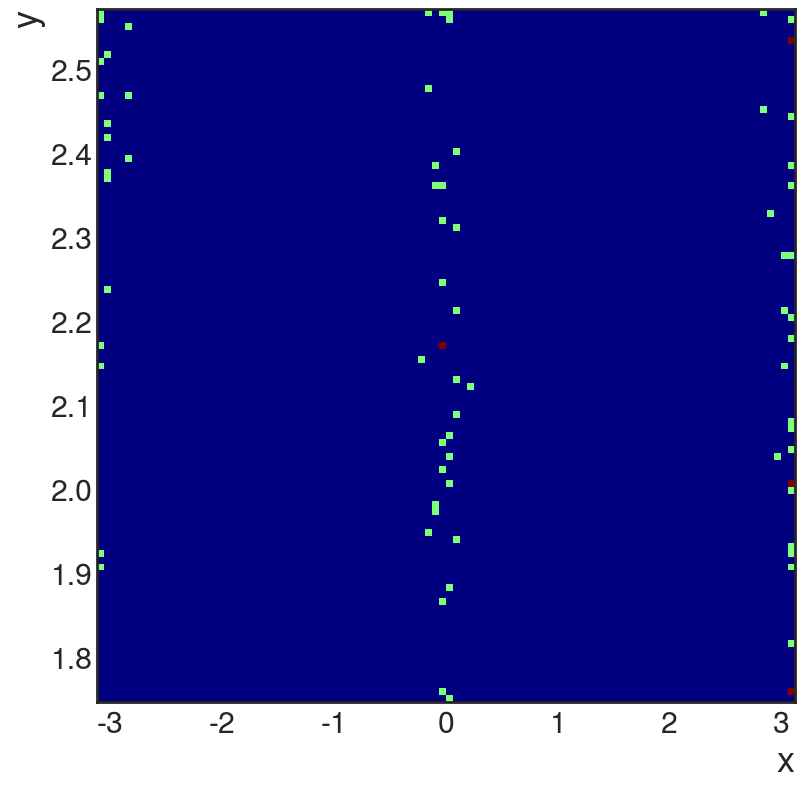

In [23]:
plt.figure(figsize=(9,9))
plt.hist2d(phis,etas,bins=(100,100),cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('./three hits histograms/colormap_etaphi.png',bbox_inches='tight')

Text(0, 1, 'y')

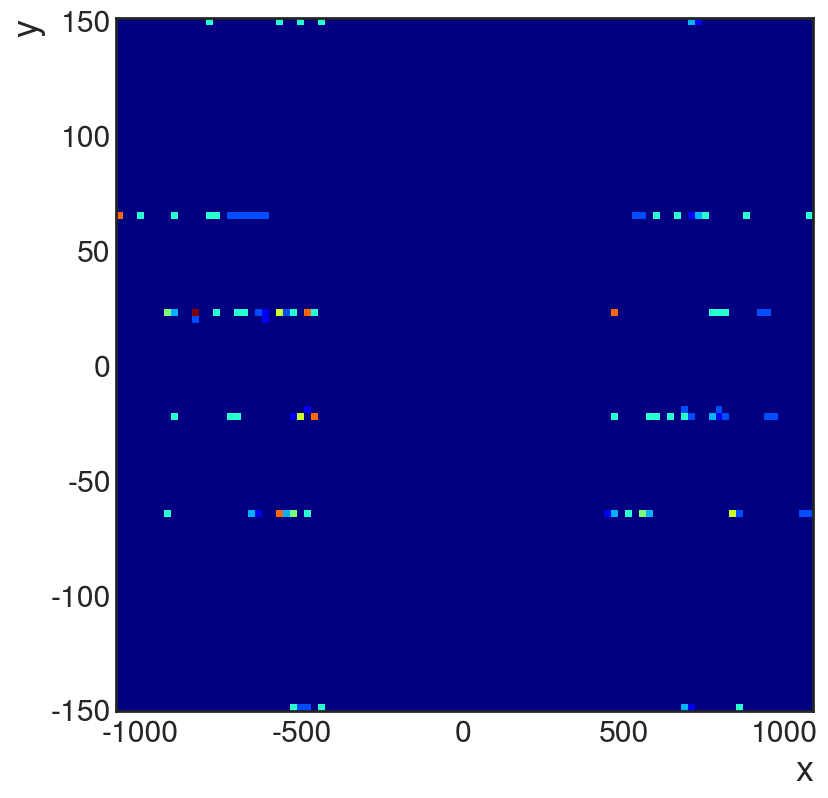

In [24]:
plt.figure(figsize=(9,9))
plt.hist2d(x,y,bins=(100,100),cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('./three hits histograms/colormap.png',bbox_inches='tight')

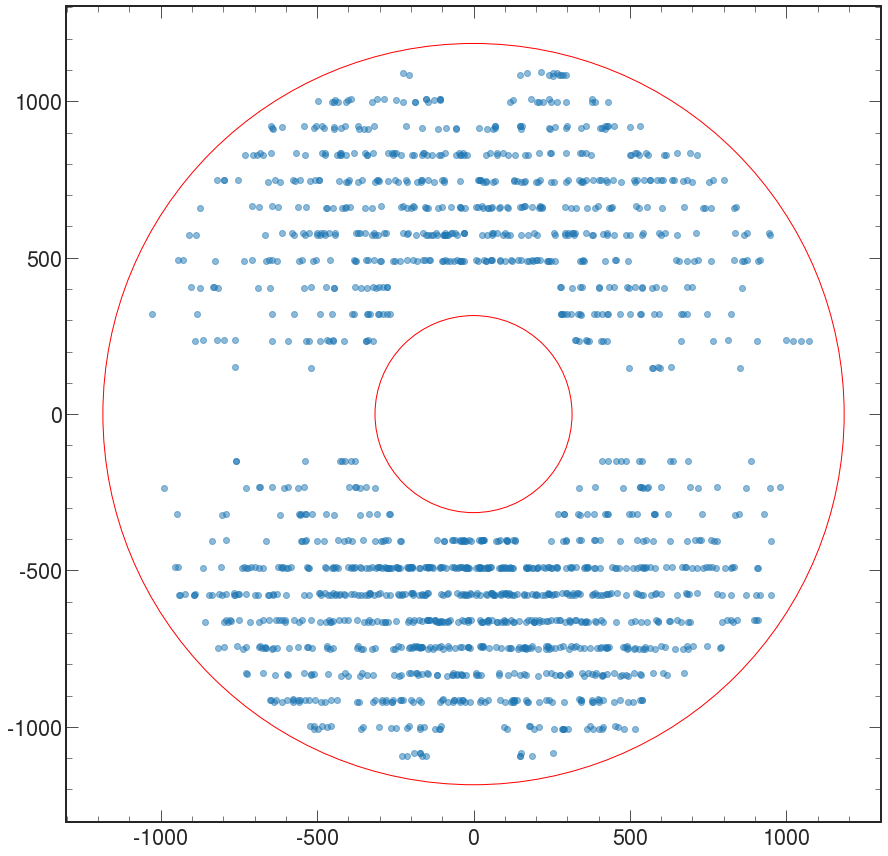

In [6]:

inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

x,y = [key.x for key in filtered_dict_traject], [key.y for key in filtered_dict_traject]

plt.scatter(x,y,alpha=0.5)


plt.axis('scaled')
# plt.savefig('zero hits original filtered.png')
plt.show()

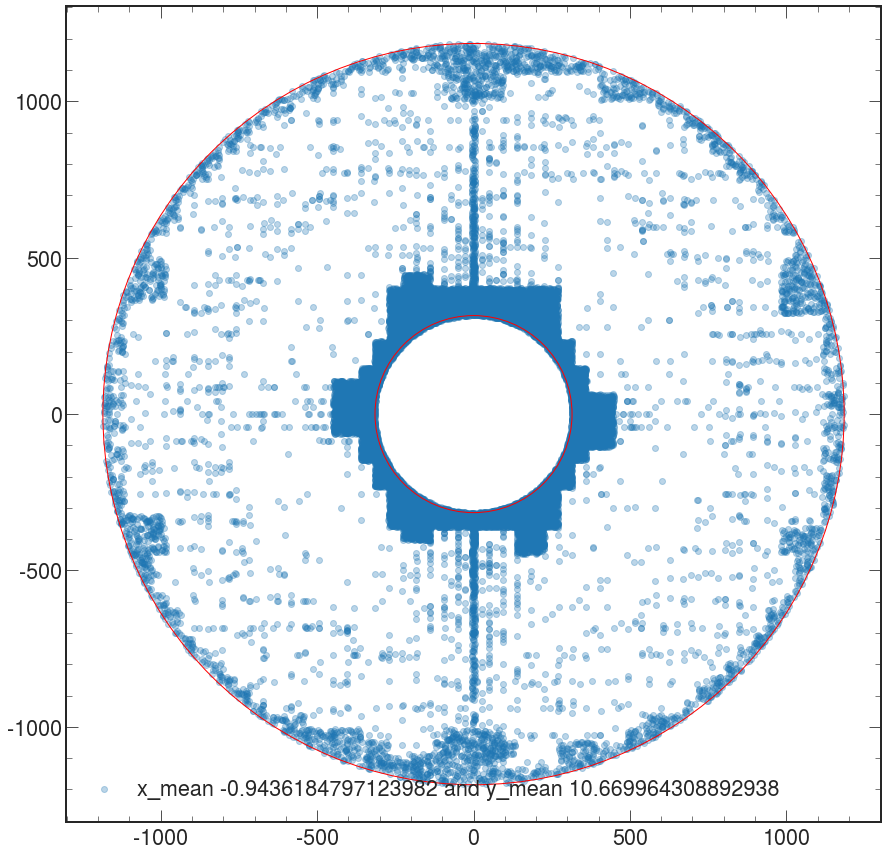

In [7]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

x = [i[0] for i in zero_hit_original]
y = [i[1] for i in zero_hit_original]
plt.scatter(x,y,alpha=0.3,label=f'x_mean {np.mean(x)} and y_mean {np.mean(y)}')
plt.legend()
plt.axis('scaled')
# plt.savefig('zero hits original filtered.png')
plt.show()

## code to deal with all files in the yaml directory, calculating efficiencs, fraction of specific hits etc.

In [3]:
hists_1 = []
configs = range(0,7)
overall_efficiency = []
headers = ['config','f1','f2','f3','f4']
data = []

for file in os.listdir('new_yamls_configs'):
    if 'filtered' in file and 'ipynb' not in file:
        with open(f'new_yamls_configs/{file}') as f:
            database_new = load(f, Loader=Loader)

        disk_new = database_new['new'] 
        new_layout = {}

        if file == 'database_new_config_0 filtered 800.yaml':
            s = Sensor2(42.5, 22)
        else:
            s = Sensor2(21.4, 21.6)

        new_layout['D1'] = Dee(315, 1185)
        new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

        new_layout['D2'] = Dee(315, 1185)
        new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

        new_layout['D3'] = Dee(315, 1185)
        new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

        new_layout['D4'] = Dee(315, 1185)
        new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

        # new_layout['D1'] = Dee(315, 1185)
        # new_layout['D1'].fromCenters2(disk_new['disk1']['front'], s, m_pix, n_pix, gap)

        # new_layout['D2'] = Dee(315, 1185)
        # new_layout['D2'].fromCenters2(disk_new['disk1']['back'], s, m_pix, n_pix, gap)

        # new_layout['D3'] = Dee(315, 1185)
        # new_layout['D3'].fromCenters2(disk_new['disk2']['front'], s, m_pix, n_pix, gap)

        # new_layout['D4'] = Dee(315, 1185)
        # new_layout['D4'].fromCenters2(disk_new['disk2']['back'], s, m_pix, n_pix, gap)

        hits = {
            # 'TDR':[],
            # 'large_sensor':[],
            # #'large_sensor_v1':[], # with shift
            # 'small_sensor':[],
            # #'small_sensor_v1':[], # with shift
            # #'small_sensor_v2':[],
            # #'small_sensor_v3':[], # with shift
            'new_layout': [],
            }

        nHits = {
            # 'TDR':[],
            # 'large_sensor':[],
            # #'large_sensor_v1':[], # with shift
            # 'small_sensor':[],
            # #'small_sensor_v1':[], # with shift
            # #'small_sensor_v2':[],
            # #'small_sensor_v3':[], # with shift
            'new_layout': [],
        }

        detector_variants = {

            # 'large_sensor': large_sensor,
            # #'large_sensor_v1': large_sensor_v1,
            # 'small_sensor': small_sensor,
            # #'small_sensor_v1': small_sensor_v1,
            # #'small_sensor_v2': small_sensor_v2,
            # #'small_sensor_v3': small_sensor_v3,
            # 'TDR': TDR,
            'new_layout': new_layout,
                }



        # We also want to get the number of hits.
        for v in vec_list:



            for det in detector_variants:
                n = 0
                iLayer = 0

                for layer in ['D1','D2','D3','D4']:
                    x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
                    y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
                    x,y = ((v.x + x_shift), (v.y + y_shift))

                    if detector_variants[det][layer].intersect(x, y):
                        n += 1
                    iLayer += 1

                if n>0: hits[det].append(v)
                nHits[det].append(n)

        # f0 = len(list(filter(lambda x:x==0,nHits['new_layout'])))/len(nHits['new_layout'])
        f1 = len(list(filter(lambda x:x==1,nHits['new_layout'])))/len(nHits['new_layout'])
        f2 = len(list(filter(lambda x:x==2,nHits['new_layout'])))/len(nHits['new_layout'])
        f3 = len(list(filter(lambda x:x==3,nHits['new_layout'])))/len(nHits['new_layout'])
        f4 = len(list(filter(lambda x:x==4,nHits['new_layout'])))/len(nHits['new_layout'])

        row = [re.findall('[0-9]',file)[0]]
        row.extend([f1,f2,f3,f4])
        data.append(row)
        print(file,f1,f2,f3,f4)
        # T = 46
        # resolution = (f1*T + (f2*T)/np.sqrt(2) + (f3*T)/np.sqrt(3))/(f1+f2+f3)
        # resolution2 = (f1*T + (f2*T)/np.sqrt(2))/(f1+f2)
        # # print(f0+f1+f2+f3)
        # print(T,T/np.sqrt(2))
        # print(resolution2,file)

        eff = len(hits['new_layout'])/len(vec_list)
        overall_efficiency.append(eff)
    #     if i == 0:
    #         unfilled_eff = len(hits['new_layout'])/len(vec_list)
    #     else:
    #         filled_eff = len(hits['new_layout'])/len(vec_list)




        # num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
        # num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
        # num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
        # #num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)


        num1 = Hist1D([v.r for v in hits['new_layout']], bins=bins_1)
    #     num2 = Hist1D([v.phi for v in hits['new_layout']], bins=bins_2)
    #     num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins_3)
        #num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
        #num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
        #num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)



        # h0 = num0.divide(den, binomial=True)
        h1 = num1.divide(den1, binomial=True)
    #     h2 = num2.divide(den2, binomial=True)
    #     h3 = num3.divide(den3, binomial=True)
        #h4 = num4.divide(den, binomial=True)
        #h5 = num5.divide(den, binomial=True)
        #h6 = num6.divide(den, binomial=True)
        hists_1.append(h1)
    #     hists_2.append(h2)
    #     hists_3.append(h3)

# fig, ax = plt.subplots(1,1,figsize=(10,10))

# for i in range(len(hists_1)):
#     if i != len(hists_1)-1:
#         hists_1[i].plot(show_errors=True,color=colors[i],label=f'config {configs[i+1]}: %.2f'%(overall_efficiency[i]),alpha=0.7)
#     else:
#         hists_1[i].plot(show_errors=True,color=colors[i],label=f'config original: %.2f'%(overall_efficiency[i]),alpha=0.7)
# ax.set_ylabel('Efficiency')
# ax.set_xlabel('r (mm)')
# ax.set_ylim(0.05,1.05)

# fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )


# fig.savefig('all_congifs_r_filtered')

database_new_config_1 filtered 800 0.23383 0.501 0.00677 0.0
database_new_config_6 filtered 800 0.22903 0.5058 0.00666 0.0
database_new_config_0 filtered 800 0.21845 0.52437 0.0093 0.0
database_new_config_2 filtered 800 0.23548 0.48146 0.01836 0.00041
database_new_config_5 filtered 800 0.24064 0.44412 0.02757 0.0017
database_new_config_4 filtered 800 0.23672 0.48216 0.00653 0.0
database_new_config_3 filtered 800 0.2282 0.51315 0.00682 0.0


## writing information to a csv file

In [4]:
with open('all_fractions filtered.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(headers)

    # write multiple rows
    writer.writerows(data)